In [16]:
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a dictionary.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
            
        dictionary: dic
            name of the dictionary wwith the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """

    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)
    

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../New_ARMOR/'
#dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
#fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
#c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

/venv/py3-phyocean/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/venv/py3-phyocean/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/venv/py3-phyocean/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/venv/py3-phyocean/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationW

In [61]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [62]:
coord = 'gul'
gul = Crops(coord, c_armor1, reg_ext)

In [63]:
gul.mlotst

<xarray.DataArray 'mlotst' (time: 729, latitude: 60, longitude: 120)>
dask.array<getitem, shape=(729, 60, 120), dtype=float64, chunksize=(53, 60, 120), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
  * longitude  (longitude) float32 -74.875 -74.625 -74.375 ... -45.375 -45.125
  * time       (time) datetime64[ns] 2005-01-01 2005-01-08 ... 2018-12-15
Attributes:
    long_name:      Optimal mixed layer depth
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_theta_and_si...
    unit_long:      meter
    units:          m

In [64]:
stacked = gul.stack(z=('longitude', 'latitude'))

In [65]:
stacked.mlotst
stk = stacked.dropna(dim='z', how='any')

In [66]:
# Run the PCA analysis:
n_components = 10  # Rq: n_components cannot exceed ncols !
pca = PCA(n_components=n_components)
pca.fit(stk.mlotst.T)

PCA(n_components=10)

In [67]:
print(pca.explained_variance_ratio_)

[0.45406435 0.03595811 0.02544649 0.02104531 0.01658713 0.01577544
 0.01420142 0.01318192 0.01190809 0.01020234]


In [68]:
print(pca.singular_values_)

[49085.71126569 13813.21564749 11620.11207965 10567.54376433
  9381.70951132  9149.28555534  8680.84973962  8363.45548004
  7949.09012656  7357.77078491]


In [69]:
reduced_values = pca.transform(stk.mlotst.T)

In [70]:
print(pca.components_.size)

7290


In [71]:
# Put all components_ analysis data to the dataset
stk['reduced_data'] = xr.DataArray(reduced_values, dims=['sample', 'n_eof'])
stk['eigen_values'] = xr.DataArray(pca.components_, dims=['n_eof', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
stk['explained_variance'] = xr.DataArray(pca.explained_variance_ratio_*100, 
                                        dims=['n_eof'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

In [72]:
stk

<xarray.Dataset>
Dimensions:             (n_eof: 10, sample: 6221, time: 729, week: 729, z: 6221)
Coordinates:
  * time                (time) datetime64[ns] 2005-01-01 ... 2018-12-15
  * z                   (z) MultiIndex
  - longitude           (z) float64 -74.88 -74.88 -74.88 ... -45.12 -45.12
  - latitude            (z) float64 30.12 30.38 30.62 ... 43.38 44.62 44.88
Dimensions without coordinates: n_eof, sample, week
Data variables:
    mlotst              (time, z) float64 dask.array<chunksize=(52, 6221), meta=np.ndarray>
    reduced_data        (sample, n_eof) float64 -273.5 -241.7 ... 39.48 -31.26
    eigen_values        (n_eof, week) float64 0.03369 0.02748 ... 0.01595
    explained_variance  (n_eof) float64 45.41 3.596 2.545 ... 1.318 1.191 1.02
Attributes:
    title:                     ARMOR3D REP - Optimal MLD for Global Ocean Obs...
    description:               ARMOR3D-REP-V4 CMEMS-V3
    Conventions:               CF-1.0
    institution:               CLS
    domain_name:               GLO
    history:                   Fri May 29 02:55:09 2020: ncap2 -O -s where(lo...
    NCO:                       4.0.8
    nco_openmp_thread_number:  1

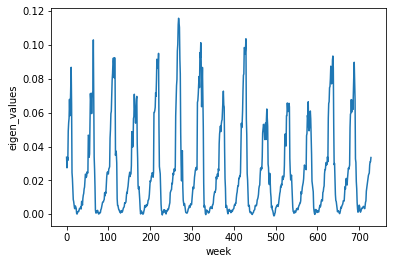

In [78]:
stk['eigen_values'][0].plot(hue='n_eof')
plt.show()

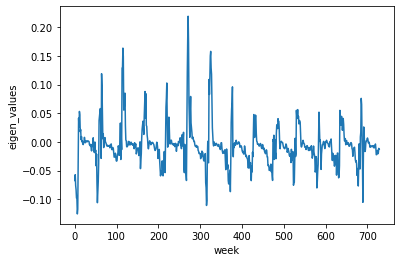

In [81]:
stk['eigen_values'][1].plot(hue='n_eof')
plt.show()

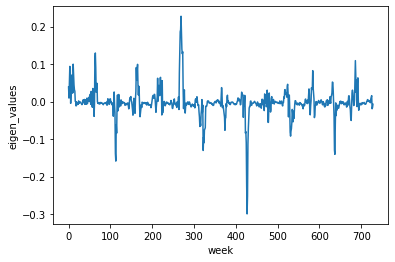

In [82]:
stk['eigen_values'][3].plot(hue='n_eof')
plt.show()

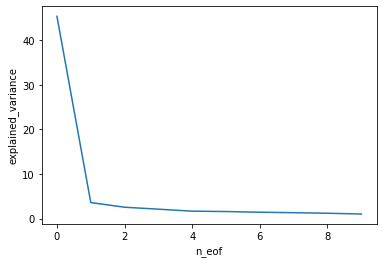

In [80]:
stk['explained_variance'].plot()

